## Hybrid Ice Stream Split

Trying to change the bed geometry to slope in both directions, and include accumulation zone instead of boundary condition.

Import firedrake and other tools.

In [1]:
import firedrake
import icepack
import matplotlib.pyplot as plt
import numpy as np

/home/sorenthompson/firedrake/src/ngsPETSc/ngsPETSc/eps.py:10: UserWarning: Import Warning: it was not possible to import SLEPc
  warnings.warn("Import Warning: it was not possible to import SLEPc")
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Define bed parameters, initialize mesh, and set up function spaces for scalars (Q) and vectors (V).

In [2]:
Lx_land = 50e3
Lx_land_accum = 10e3
Lx_water_accum = 10e3
Lx_water = 75e3

Lx_l = Lx_land + Lx_land_accum
Lx_r = Lx_water_accum + Lx_water

nx_land = 72
nx_accum = 72
nx_water = 72

nx = nx_land + nx_accum + nx_water

mesh1d = firedrake.IntervalMesh(nx, -Lx_l, Lx_r)
mesh = firedrake.ExtrudedMesh(mesh1d, layers = 1)

Q = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="R", vdegree=0)
V = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="GL", vdegree=2)

Import a couple constant values from icepack.

In [3]:
from icepack.constants import(
    ice_density as rho_ice,           # ρ_I | 9.21e-19
    water_density as rho_water,       # ρ_W | 1.03e-18
    weertman_sliding_law as weertman, # m   | 3.0
    gravity as g,                     # g   | 9.77e15
)

Set up bed geometry.

Bed is defined in three sections based on two gaussian curves on either side of a flat icefield.

$$
bed= a * e^{-\frac{(x-b)^2}{2c^2}} + d
$$

a = maximum bed height - minimum bed height

b = position of border between accumulation and sloping areas (`-Lx_land_accum` and `Lx_water_accum`)

c = slope control aka width of curve. `Lx_land/3` and `Lx_water/3.5` are currently used.

d = minimum bed height

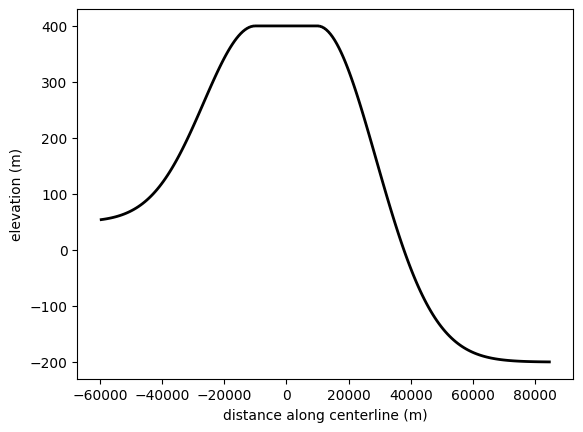

In [4]:
from firedrake import max_value, min_value
from firedrake import conditional, eq, ne, le, ge, lt, gt

x,z = firedrake.SpatialCoordinate(mesh)

b_min_land = 50
b_accum = 400
b_min_water = -200

b_land = (b_accum - b_min_land) * firedrake.exp(-((x+Lx_land_accum)**2)/(2*(Lx_land/3)**2)) + b_min_land
b_water = (b_accum - b_min_water) * firedrake.exp(-((x-Lx_water_accum)**2)/(2*(Lx_water/4)**2)) + b_min_water

b = firedrake.interpolate(conditional(lt(x, -Lx_land_accum),b_land,
                                      conditional(lt(x, Lx_water_accum), b_accum, b_water)),Q)

fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")
firedrake.plot(icepack.depth_average(b), axes=axes);

Calculate initial height and surface.

$\tau_D$ = driving stress

$$
\tau_D = -\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}
$$

where $g = $ gravity

$h_{in} = $ incoming height

$\frac{\delta s}{\delta x}$ = surface slope

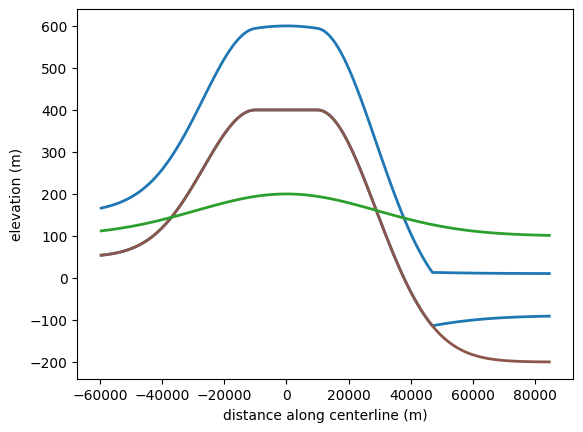

In [5]:
height_max = 200
height_min = 100
height_x = (height_max - height_min) * firedrake.exp(-((x-(Lx_water_accum - Lx_land_accum)/2)**2)/(2*((Lx_l+Lx_r)/5)**2)) + height_min
h0 = firedrake.interpolate(height_x, Q)
s0 = icepack.compute_surface(thickness=h0, bed=b)

fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

zb0 = firedrake.interpolate(s0-h0, Q)
firedrake.plot(icepack.depth_average(zb0), edgecolor="tab:blue", axes = axes);
firedrake.plot(icepack.depth_average(s0), edgecolor="tab:blue", axes = axes);
firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes);
firedrake.plot(icepack.depth_average(h0), edgecolor="tab:green", axes=axes);

Estimate intial velocities, negative in the land-terminating area and positive in the water-terminating area. It is assumed that the dividing line is at position $x=0$. 

$$
u_x = u_{in} + (u_{out} - u_{in}) * \left(\frac{x}{Lx}\right)^2
$$

Just an interpolation between $u_{in}$ and $u_{out}$ using a square.

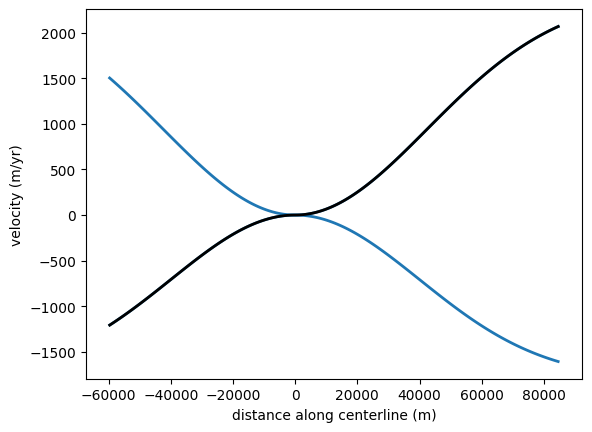

In [6]:
u_out_land = -1800
u_out_water = 2400

velocity_x_land = -u_out_land * firedrake.exp(-(x**2)/(2*(Lx_l/1.5)**2)) + u_out_land
velocity_x_water = -u_out_water * firedrake.exp(-(x**2)/(2*(Lx_r/2)**2)) + u_out_water

u0_l = firedrake.interpolate(velocity_x_land, V)
u0_r = firedrake.interpolate(velocity_x_water, V)
u0 = firedrake.interpolate(conditional(lt(x,0),u0_l, u0_r),Q)

fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("velocity (m/yr)")
firedrake.plot(icepack.depth_average(u0_l), edgecolor="tab:blue", axes=axes);
firedrake.plot(icepack.depth_average(u0_r), edgecolor="tab:blue", axes=axes);
firedrake.plot(icepack.depth_average(u0), axes=axes);

Set up icepack values.

water pressure = water density * gravity * amount of ice under the water line (elevation = 0)
ice pressure = ice density * gravity * ice height
phi = ramping function for friction.
- If no water pressure, then phi = 1.
- If ice pressure equals water pressure, then phi = 0.

$C$ = Friction Coeff

$$
C = (0.95 - 0.05 \frac{x}{Lx}) \times \frac{\tau_D}{u_{in}^{1/3}}
$$

where $\tau_D =$ driving stress
and $u_{in} = $ incoming velocity at source

Expanding the driving stress, this is

$$
C = -\left(0.95 - 0.05 \frac{x}{Lx}\right) \times \frac{\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}}{u_{in}^{1/3}}
$$

$C$ decreases slightly along length, then is a ratio of driving stress and incoming velocity

In [28]:
# Temperature = firedrake.Constant(255.0) # -18 deg C
Temperature = firedrake.Constant(272.0) # -1 deg C
A = icepack.rate_factor(Temperature) # flow rate factor

from firedrake import grad, dx
# surface_slope = firedrake.interpolate(grad(s0),V)
# surface_slope = grad(s0)
# surface_slope = s0 * dx

# print(s0.dat.data)
# print(surface_slope.dat.data)

# fig, axes = plt.subplots()
# axes.set_xlabel("distance along centerline (m)")
# axes.set_ylabel("velocity (m/yr)")
# firedrake.plot(icepack.depth_average(surface_slope), axes=axes);


# h_in = s_in - b_in
# surface_slope = (s_out - s_in) / Lx # δs_δx
# surface_slope =
# tau_D = -rho_ice * g * h_in * surface_slope # driving stress
# C = firedrake.interpolate((0.95 - 0.05 * x/Lx) * tau_D / u_in ** (1/weertman), Q) # Friction Coeff

$\phi$ = relative pressure at that point

$p_w =$ upward pressure of submerged ice

$p_I = $ downward pressure of unsubmerged ice

In [ ]:
p_water = rho_water * g * max_value(0, h0 - s0) # Prevents negative thickness
p_ice = rho_ice * g * h0
phi = 1 - p_water / p_ice # Are there issues if phi = 0?

#### Weertman friction
The law defines the driving stress as

$$
\tau_b = -C|u|^{\frac{1}{m}-1}u
$$

And the energy dissipation is

$$
E(u) = \int \frac{m}{m + 1}C|u|^{\frac{1}{m} + 1}dx.
$$

Weertman is already implemented in Icepack in the `icepack.models.hybrid.bed_friction(velocity = u, friction = C*phi)` function below.

#### Schoof friction approximation

This is implemented in the Synthetic Flowline Ice Stream tutorial as an approximation of the Schoof sliding law. When the velocity is small, energy dissipation acts relative to $|u|^1$, and when it is large, it acts relative to $|u|^{\frac{1}{m}+1}$. The factor $-U_0$ means that there is no flow when there is no energy dissipation.

$$
E(u) = \int \tau_0 \left( \left( U_0^{\frac{1}{m}+1}+|u|^{\frac{1}{m}+1}\right)^{\frac{m}{m+1}} - U_0 \right) dx
$$

In the implementation, $\tau_0$ is

$$
\tau_0 = C \left( U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}}\right)^{\frac{1}{m+1}}
$$

$\phi$ is implemented the same as above, where the amount of water displaced is the height of ice submerged $h_{sub} = h-s$

$$
\phi = 1 - \frac{\rho_{water}}{\rho_{ice}} \frac{(h_{sub})}{h_{supra}}
$$

Finally, friction is calculated as

$$
\tau_0 \times \phi \times \left(\left(U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}} \right)^{\frac{1}{m+1}} - U_0 \right)
$$


In [ ]:
from firedrake import sqrt, inner

U_0 = firedrake.Constant(50) 
U = sqrt(inner(u0, u0)) # Sqrt of dot product, a way to get the magnitude of u
tau_0 = firedrake.interpolate(
    C*( U_0**(1/weertman+1) + U**(1/weertman+1) )**(1/(weertman+1)), Q
)

In [ ]:
import icepack.models.hybrid

## Weertman friction
def weertman_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice
    
    return icepack.models.hybrid.bed_friction(
        velocity = u,
        friction = C * phi,
    )

def schoof_approx_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]
    
    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice

    U = sqrt(inner(u, u))
    return tau_0 * phi * (
        (U_0**(1/weertman+1) + U**(1/weertman+1))**(weertman/(weertman+1))-U_0
    )

Set up hybrid model solver with custom friction function and initialize the velocity field.

In [ ]:
model = icepack.models.HybridModel(friction = schoof_approx_friction)
opts = {
    "dirichlet_ids": [1],
    #"diagnostic_solver_type": "petsc",
    #"diagnostic_solver_parameters": {"snes_type": "newtontr"},
}

solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity = u0,
    thickness = h0,
    surface = s0,
    fluidity = A,
    friction = C,
)

Plot new initial velocities.

In [ ]:
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("speed (m / yr)")
firedrake.plot(icepack.depth_average(u0), axes=axes);

### Run the actual model

In [ ]:
h_min = 10 # base height past the terminus/"empty" portion of the glacier
h_calving = 50 # the height the glacier calves at.
cal_step = h_calving - h_min

In [ ]:
import tqdm

num_years = 100
timesteps_per_year = 2

dt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q) # Ramping accumulation along length
h = h0.copy(deepcopy = True)
u = u0.copy(deepcopy = True)

height_min1 = np.zeros(num_timesteps) * np.nan
height_min2 = np.zeros(num_timesteps) * np.nan
endpoints = np.zeros(num_timesteps) * np.nan

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness = h,
        velocity = u,
        accumulation = a,
        thickness_inflow = h0,
    )
    
    height_min1[step] = h.dat.data_ro.min()

    h = icepack.interpolate(conditional(lt(h,h_calving),h_min,h),Q) # Calving to minimum stable value (use UFL for functions)
    
    s = icepack.compute_surface(thickness=h, bed=b)

    u = solver.diagnostic_solve(
        velocity = u,
        thickness = h,
        surface = s,
        fluidity = A,
        friction = C,
    )

    height_min2[step] = h.dat.data_ro.min()

Plot profile.

In [ ]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)
zb = firedrake.interpolate(s-h, Q)
firedrake.plot(icepack.depth_average(zb), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(s), edgecolor="tab:blue", axes = axes);

In [ ]:
print(endpoints)